# Analyze: データから価値を創出できるか診断する

## なにをするのか

今あるデータの質・量がBusiness Understandingで決めた価値を実現するのに十分か診断されていることがAnalyzeのゴールです。診断結果に基づき次のPrepareでデータを用意します。

## なぜやるのか

データ分析ではGarbage in Garbage outという言葉があります。データが十分でなければ十分でない結果が出るということです。データが十分でないプロジェクトに診断結果をもって待ったをかけ、進めるために必要な要件を提示するのがAnalyzeの目的です。例えば[機械学習プロジェクトの成功率100%を誇るPositronic](https://www.positronic.ai/?utm_source=aimultiple&utm_medium=research&utm_campaign=ai-fail)では、プロジェクト開始前に顧客がデータを持っているかに関して厳しく確認しており、分類では1カテゴリ10,000件あることを要件としています。また、[AIプロダクト品質保証ガイドライン](https://www.qa4ai.jp/)の2021年9月版では「2.1 AI プロダクトの品質保証の基本的考え方」において「まず品質の高いAIプロダクトを開発するためには、データがきちんとしていなくてはならない」と冒頭に記述があります。

そもそも機械学習を使うほど業務判断が複雑なのかも、Analyzeのプロセスで明らかにします。

## どうやるのか

プログラミング演習でデータの質と量の分析を行い、コミュニケーション演習で分析結果の確認をします。

### プログラミング演習

不動産の価格データを用いて、データの質と量を分析します。予測対象は物件価格とします。

#### **量の分析**

データを読み込み、量を把握します。最終的にどの程度の量が必要なのかは、質の分析を終えてから判断することになります。というのも、識別しやすいデータであれば少なく済みますし難しければより量が必要だからです。最初は有効なデータ件数を確認します。

今回は`house_prices.csv`というデータを渡されているとし、それを`house_price_df`という変数に読み込みます。データの読み込みには`pandas`というライブラリを使用します。

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np


raw_data_path = Path("../data/raw/house_prices.csv")
house_price_df = pd.read_csv(raw_data_path, na_values="?")
print(len(house_price_df))

1460


1460件のデータがあることがわかりました。しかしこのうちどの程度が有効なデータでしょうか。

`info`関数でデータの列名、形式、空白(null)でない値の件数がわかります。

*Exercise: `info`を`describe`に変更してみましょう。データ各列の平均や分散(基本統計量)を参照できます。*

In [2]:
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

データ件数をプロットすることで空白が多い項目を視覚的に把握することができます。次のコードで、空白データの割合を棒グラフで表示します。

*Exercise: `barh`を`bar`に変更してみましょう。利用可能なチャートは[Chart Visualization](https://pandas.pydata.org/docs/user_guide/visualization.html#area-plot)で確認できます。*

<AxesSubplot:ylabel='index'>

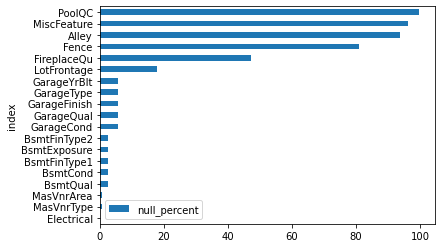

In [3]:
null_percents = house_price_df\
   .isnull().sum().divide(len(house_price_df)).multiply(100)\
   .reset_index(name="null_percent").query("null_percent > 0.0")\
   .sort_values("null_percent")\
   .set_index("index")

null_percents.plot.barh()

In [4]:
null_percents.index[(null_percents > 50).to_numpy().flatten()]

Index(['Fence', 'Alley', 'MiscFeature', 'PoolQC'], dtype='object', name='index')

* **`Fence`, `Alley`, `MiscFeature`, `PoolQC`は半分以上空白であり、除去したほうがよさそうであることがわかります。**

##### **データの偏りの分析**

次に、予測する項目についてデータの偏りを調べます。データが偏っていると、特定範囲のみしか予測できないモデルになります。分類問題であれば、データ量が多いカテゴリ以外予測されずらくなります。
予測する項目`SalePrice`の分布を調べるには、ヒストグラムが役立ちます。

<AxesSubplot:ylabel='Frequency'>

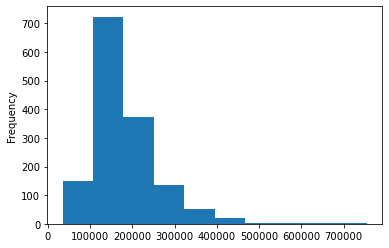

In [5]:
house_price_df["SalePrice"].plot.hist()

だいたい10万ドル~20万ドル程度に分布していることがわかりますが、中には70万ドルを超えるような物件があります。[箱ひげ図](https://cacco.co.jp/datascience/blog/statistics/203/)を使うとデータの傾向を可視化できます。

![02_analyze_001.PNG](images/02_analyze_001.PNG)

<AxesSubplot:>

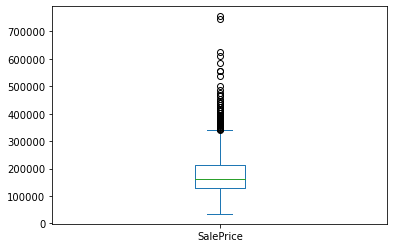

In [6]:
house_price_df["SalePrice"].plot.box()

外れ値の境界を求めてみましょう。

In [7]:
box_body = house_price_df["SalePrice"].describe()["75%"] - house_price_df["SalePrice"].describe()["25%"]
sale_price_upper = house_price_df["SalePrice"].describe()["75%"] + 1.5 * box_body
sale_price_upper

340037.5

`SalePrice`の分析から、次のことが言えそうです。

* **34万ドル以上は外れ値とみえる。除外するか、データを増やす必要がある。**

#### 質の分析

質の分析では、予測したい項目に相関がある特徴があるか、特徴間に相関がないかを調べます。特徴には様々な種類がありますが、ここでは数値項目とカテゴリ項目を扱います。カテゴリ項目とは、ドロップダウンリストから選ぶような項目(間取りがA、B、Cの3つなど)です。

##### **予測する項目との相関**

予測したい`SalePrice`と相関を持つ特徴があれば質が高いデータといえます。予測したい販売価格(`SalePrice`)と各特徴の相関を計算することで関係の強さを判断できます。項目同士の相関は`corr`関数で計算できます。

`SalePrice`と数値項目の相関から見ていきましょう。

<AxesSubplot:>

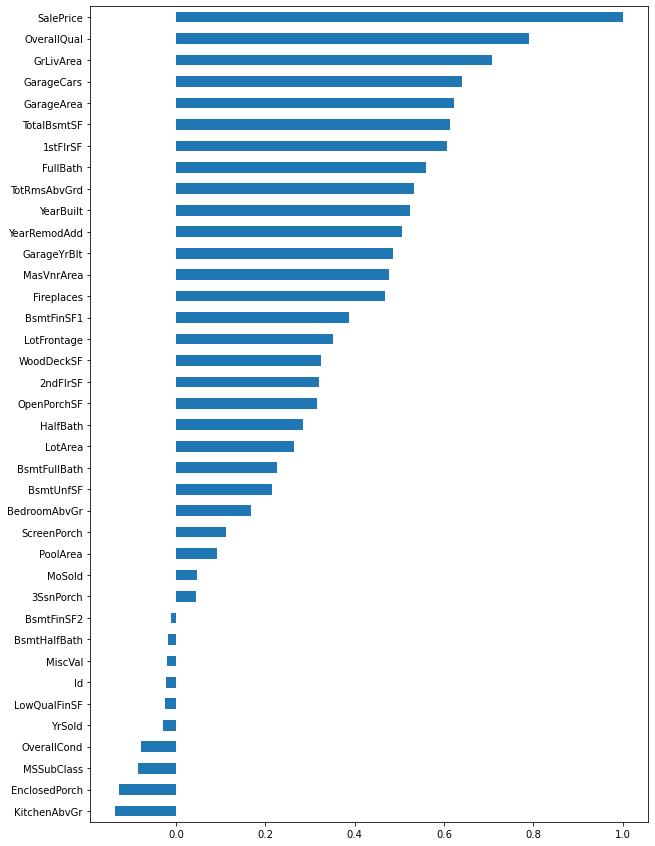

In [8]:
numerical_df = house_price_df.select_dtypes("number")
numerical_df.corr()["SalePrice"].sort_values().plot.barh(figsize=(10,15))

* **`OverallQual`などの特徴が価格の予測に影響していることがわかります。**  
(※`SalePrice`と`SalePrice`の相関が高いのは当然です)。

カテゴリ項目についても見ていきましょう。ただ、カテゴリ項目は数値ではないので相関が計算できません。なので、数値への変換が必要です。A、B、Cなら0、1、2にしてしまうなどです。ただし、数値に変換することで数値間の関係(CはBの2倍など)が発生してしまいます。数値に変換してもよいか確認して行う必要があります。今回は単に数値に変換して相関を計算します。

<AxesSubplot:>

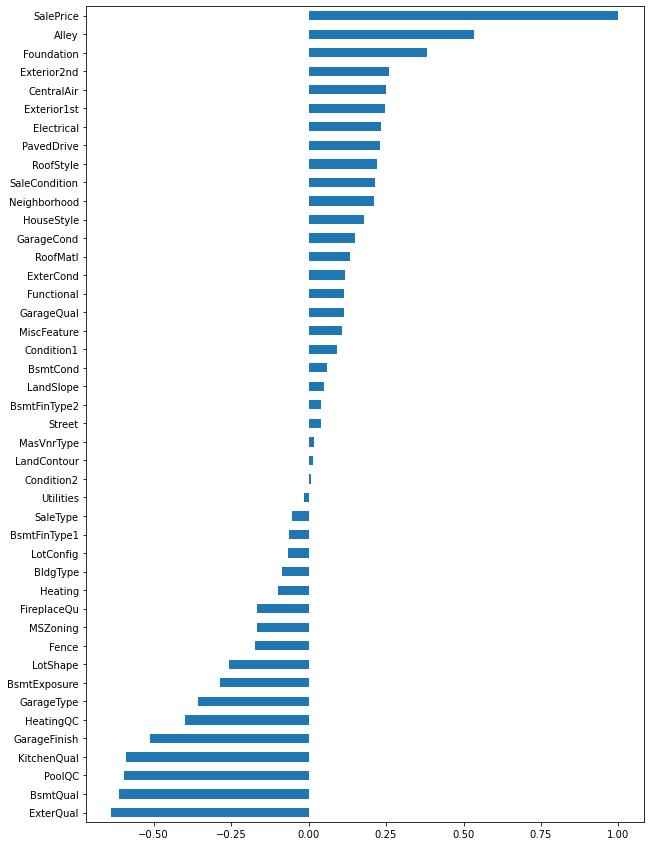

In [9]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder


categorical_df = house_price_df[house_price_df.columns.difference(numerical_df.columns)]
categorical_numbers = OrdinalEncoder().fit_transform(categorical_df)
categorical_numbers_df = pd.DataFrame(categorical_numbers, columns=categorical_df.columns)
categorical_numbers_df.insert(0, "SalePrice", house_price_df["SalePrice"])
categorical_numbers_df.corr()["SalePrice"].sort_values().plot.barh(figsize=(10,15))

* **`Alley`や`Foundation`とは正の相関があり、`ExterQual`や`BsmtQual`とは負の相関があることがわかります。**

##### **特徴間の相関**

特徴間で相関が高いと、重複している傾向を持つ特徴があると推察できます。特徴間に相関があるとモデルのパラメーターをうまく求めることができなくなるため、除去しておく必要があります。

数値項目から見ていきましょう。

In [10]:
corr = numerical_df.corr()
corr.style.background_gradient(cmap="Blues").set_precision(2)

C:\Users\ttaakkaa\AppData\Local\Temp\ipykernel_18088\1254225876.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap="Blues").set_precision(2)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.00,0.01,-0.01,-0.03,-0.03,0.01,-0.01,-0.02,-0.05,-0.01,-0.01,-0.01,-0.02,0.01,0.01,-0.04,0.01,0.00,-0.02,0.01,0.01,0.04,0.00,0.03,-0.02,0.00,0.02,0.02,-0.03,-0.00,0.00,-0.05,0.00,0.06,-0.01,0.02,0.00,-0.02
MSSubClass,0.01,1.00,-0.39,-0.14,0.03,-0.06,0.03,0.04,0.02,-0.07,-0.07,-0.14,-0.24,-0.25,0.31,0.05,0.07,0.00,-0.00,0.13,0.18,-0.02,0.28,0.04,-0.05,0.09,-0.04,-0.10,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.01,-0.39,1.00,0.43,0.25,-0.06,0.12,0.09,0.19,0.23,0.05,0.13,0.39,0.46,0.08,0.04,0.40,0.10,-0.01,0.20,0.05,0.26,-0.01,0.35,0.27,0.07,0.29,0.34,0.09,0.15,0.01,0.07,0.04,0.21,0.00,0.01,0.01,0.35
LotArea,-0.03,-0.14,0.43,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,0.11,-0.00,0.26,0.30,0.05,0.00,0.26,0.16,0.05,0.13,0.01,0.12,-0.02,0.19,0.27,-0.02,0.15,0.18,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,-0.03,0.03,0.25,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,-0.06,0.31,0.54,0.48,0.30,-0.03,0.59,0.11,-0.04,0.55,0.27,0.10,-0.18,0.43,0.40,0.55,0.60,0.56,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,0.01,-0.06,-0.06,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,0.04,-0.14,-0.17,-0.14,0.03,0.03,-0.08,-0.05,0.12,-0.19,-0.06,0.01,-0.09,-0.06,-0.02,-0.32,-0.19,-0.15,-0.00,-0.03,0.07,0.03,0.05,-0.00,0.07,-0.00,0.04,-0.08
YearBuilt,-0.01,0.03,0.12,0.01,0.57,-0.38,1.00,0.59,0.32,0.25,-0.05,0.15,0.39,0.28,0.01,-0.18,0.20,0.19,-0.04,0.47,0.24,-0.07,-0.17,0.10,0.15,0.83,0.54,0.48,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,-0.02,0.04,0.09,0.01,0.55,0.07,0.59,1.00,0.18,0.13,-0.07,0.18,0.29,0.24,0.14,-0.06,0.29,0.12,-0.01,0.44,0.18,-0.04,-0.15,0.19,0.11,0.64,0.42,0.37,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,-0.05,0.02,0.19,0.10,0.41,-0.13,0.32,0.18,1.00,0.26,-0.07,0.11,0.36,0.34,0.17,-0.07,0.39,0.09,0.03,0.28,0.20,0.10,-0.04,0.28,0.25,0.25,0.36,0.37,0.16,0.13,-0.11,0.02,0.06,0.01,-0.03,-0.01,-0.01,0.48
BsmtFinSF1,-0.01,-0.07,0.23,0.21,0.24,-0.05,0.25,0.13,0.26,1.00,-0.05,-0.50,0.52,0.45,-0.14,-0.06,0.21,0.65,0.07,0.06,0.00,-0.11,-0.08,0.04,0.26,0.15,0.22,0.30,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39


相関の高い数値項目をリストアップする関数を作成します。相関表は上三角と下三角が同じ値なので、同じ項目同士(対角成分)を除いた上三角部分について相関が一定値(`threshold`)以上のものをリストアップします。

In [11]:
def list_high_corr_columns(corr, threshold):

    # 相関行列の作成
    corr = corr.abs()

    # 相関行列の上三角部分を選択
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # thresholdより大きい相関を持つ項目を選択
    columns = [column for column in upper.columns if any(upper[column] > threshold)]

    return columns

In [12]:
high_corr_columns = list_high_corr_columns(corr, 0.8) 
high_corr_columns

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

* **`1stFlrSF`, `TotRmsAbvGrd`, `GarageYrBlt`, `GarageArea`は高い相関を持つ項目があるため除去したほうがよさそうなことがわかります。**

カテゴリ項目についても見ていきましょう。

カテゴリ項目間の相関を見る尺度はいくつかありますが、ここでは[クラメールの相関係数](https://corvus-window.com/excel_cramers-v/#:~:text=%E3%82%AF%E3%83%A9%E3%83%A1%E3%83%BC%E3%83%AB%E3%81%AE%E9%80%A3%E9%96%A2%E4%BF%82%E6%95%B0%E3%81%A8%E3%81%AF%E3%82%AF%E3%83%AD%E3%82%B9%E9%9B%86%E8%A8%88,%E8%A8%80%E3%81%86%E3%81%93%E3%81%A8%E3%81%8C%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%EF%BC%8E)を使用します。男性と女性とで、好きな音楽のジャンルの傾向は同じかどうかなどを調べるのに利用できます。アンケートの分析などにも使えるので、覚えておくと役に立つと思います([Excelでも計算できます](https://istat.co.jp/sk_commentary/kai2_test_02))。

※2値のカテゴリ項目の場合テトラコリック、2値ではないが順列性があるカテゴリ項目の場合ポリコリック(レビューの採点結果が男性と女性で同じかなど)、順列性がないカテゴリ項目の場合にクラメールを用います。

In [13]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_V(var1, var2) :
    # カテゴリ項目間のクロス集計表を作成
    crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    if len(crosstab) == 0:
        return np.nan
    # カイ二乗検定の値を計算(var1とvar2の分布が乖離している度合い)
    chi2 = chi2_contingency(crosstab)[0]
    # サンプル総数を計算
    n = np.sum(crosstab)
    # クロス集計表の行列要素数の少ない方(自由度)を計算
    degree = min(crosstab.shape)
    if degree == 1:
        return np.nan

    return (chi2 / (n * (degree - 1)))


def corr_categorical(df):
    rows= []
    for var1 in df.columns:
        col = []
        for var2 in df.columns:
            cramers = cramers_V(df[var1], df[var2])
            col.append(cramers)  
        rows.append(col)
    cramers_array = np.array(rows)
    df = pd.DataFrame(cramers_array, columns=df.columns, index =df.columns)
    return df

In [14]:
categorical_corr = corr_categorical(categorical_numbers_df.drop("SalePrice", axis=1))
categorical_corr.style.background_gradient(cmap="Greens").set_precision(2)

C:\Users\ttaakkaa\AppData\Local\Temp\ipykernel_18088\2920701890.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  categorical_corr.style.background_gradient(cmap="Greens").set_precision(2)


,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Foundation,Functional,GarageCond,GarageFinish,GarageQual,GarageType,Heating,HeatingQC,HouseStyle,KitchenQual,LandContour,LandSlope,LotConfig,LotShape,MSZoning,MasVnrType,MiscFeature,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Alley,0.96,0.33,0.01,0.04,0.10,0.03,0.29,0.03,0.13,nan,0.07,0.04,0.36,0.26,0.22,0.11,0.08,0.31,0.02,0.08,0.31,0.09,0.04,0.02,0.14,0.08,0.24,0.00,0.00,0.00,0.06,0.55,0.08,nan,0.64,0.09,nan,nan,0.02,0.14,0.12,nan,nan
BldgType,0.33,1.00,0.00,0.01,0.01,0.00,0.03,0.09,0.01,0.03,0.01,0.01,0.03,0.04,0.05,0.01,0.00,0.04,0.01,0.00,0.04,0.01,0.03,0.01,0.02,0.03,0.03,0.01,0.00,0.01,0.01,0.04,0.01,0.19,0.19,0.02,nan,0.01,0.01,0.03,0.02,0.02,0.00
BsmtCond,0.01,0.00,1.00,0.01,0.01,0.01,0.04,0.07,0.01,0.00,0.18,0.05,0.03,0.02,0.02,0.01,0.01,0.02,0.05,0.07,0.01,0.11,0.01,0.01,0.01,0.01,0.02,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.03,0.02,nan,0.01,0.01,0.01,0.01,0.00,0.00
BsmtExposure,0.04,0.01,0.01,1.00,0.04,0.01,0.04,0.01,0.01,0.00,0.01,0.00,0.03,0.02,0.03,0.00,0.01,0.02,0.00,0.01,0.03,0.01,0.02,0.00,0.01,0.06,0.02,0.04,0.05,0.01,0.01,0.01,0.02,0.02,0.09,0.01,0.39,0.03,0.02,0.01,0.02,0.01,0.00
BsmtFinType1,0.10,0.01,0.01,0.04,1.00,0.05,0.11,0.03,0.01,0.01,0.01,0.01,0.09,0.06,0.06,0.03,0.03,0.10,0.01,0.01,0.07,0.01,0.03,0.01,0.04,0.03,0.08,0.01,0.01,0.01,0.01,0.02,0.04,0.14,0.11,0.03,0.51,0.01,0.01,0.01,0.02,0.00,0.00
BsmtFinType2,0.03,0.00,0.01,0.01,0.05,1.00,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.03,0.02,0.01,0.01,0.02,0.01,0.00,0.01,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.01,0.18,0.04,0.00,0.71,0.02,0.01,0.00,0.01,0.01,0.02
BsmtQual,0.29,0.03,0.04,0.04,0.11,0.01,1.00,0.05,0.03,0.02,0.05,0.02,0.21,0.11,0.11,0.02,0.07,0.17,0.02,0.03,0.17,0.03,0.07,0.00,0.08,0.05,0.18,0.01,0.00,0.01,0.02,0.04,0.07,0.03,0.30,0.03,0.14,0.01,0.03,0.06,0.07,0.00,0.00
CentralAir,0.03,0.09,0.07,0.01,0.03,0.00,0.05,0.99,0.01,0.01,0.18,0.04,0.08,0.13,0.12,0.01,0.01,0.14,0.01,0.09,0.06,0.06,0.10,0.22,0.15,0.06,0.12,0.02,0.00,0.01,0.01,0.09,0.03,0.10,0.16,0.11,nan,0.00,0.01,0.02,0.02,0.00,0.00
Condition1,0.13,0.01,0.01,0.01,0.01,0.01,0.03,0.01,1.00,0.05,0.01,0.01,0.02,0.01,0.02,0.01,0.00,0.01,0.00,0.01,0.03,0.01,0.01,0.00,0.03,0.01,0.01,0.00,0.00,0.03,0.02,0.01,0.01,0.19,0.05,0.02,0.46,0.01,0.01,0.00,0.01,0.03,0.00
Condition2,nan,0.03,0.00,0.00,0.01,0.01,0.02,0.01,0.05,1.00,0.00,0.09,0.02,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.03,0.02,0.00,0.01,0.02,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.25,0.02,0.01,nan,0.00,0.10,0.00,0.00,0.00,0.00


数値項目と同様に、相関の高いカテゴリ項目を特定します。

In [15]:
categorical_high_corr_columns = list_high_corr_columns(categorical_corr, 0.5) 
categorical_high_corr_columns

['Exterior2nd', 'MSZoning', 'Neighborhood', 'PoolQC', 'SaleCondition']

* **`Exterior2nd`, `MSZoning`, `Neighborhood`, `PoolQC`, `SaleCondition`は、高い相関を持つ項目があるため除去したほうがよさそうなことがわかります。**

項目の意味や値の内容がわからない場合は、コミュニケーション演習で確認をしていきます。

### コミュニケーション演習

プログラミング演習の結果、次の傾向を発見しました。

* 量の分析
   * `Fence`, `Alley`, `MiscFeature`, `PoolQC`は半分以上空白であり、除去したほうがよさそう。
* 質の分析(予測値)
   * 34万ドル以上は外れ値とみえる。除外するか、データを増やす必要がある。
* 質の分析(数値項目)
   * `OverallQual`などの項目が価格の予測に影響している。
   * `1stFlrSF`, `TotRmsAbvGrd`, `GarageYrBlt`, `GarageArea`は高い相関を持つ項目があるため除去したほうがよさそう。
* 質の分析(カテゴリ項目)
   * `Alley`や`Foundation`とは正の相関があり、`ExterQual`や`BsmtQual`とは負の相関がある。
   * `Exterior2nd`, `MSZoning`, `Neighborhood`, `PoolQC`, `SaleCondition`は、高い相関を持つ項目があるため除去したほうがよさそう。

これらの分析結果を最終的な診断につなげるために、誰に何を依頼すべきでしょうか?

ロールの種別

| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |

依頼の種別

* 情報共有: 開発に必要な情報/ドキュメントの提供を依頼する
* 作業: 開発に必要な作業を分担(依頼)する
* レビュー: 作業の確度を上げるため/承認を得るためレビューを依頼する

![communication](images/communication.PNG)

#### ビジネスチームへの依頼例

Domain ExpertやData Analystに対して次のような依頼をするとよいでしょう。

* 情報共有の依頼
   * 業務上、どの特徴をどのような意味で入力、利用しているか。
   * 除去したほうが良い項目は、本当に除去してよいか。
   * 相関がみられる項目は、業務的な観点から相関があってしかるべきといえるか。
* 作業依頼
   * 予測項目、特徴の用途についてのドキュメント作成。
* レビュー
   * 診断結果に対するフィードバック

#### DevOpsチームへの依頼例

Data architectやSoftware Engineerに対して次のような依頼をするとよいでしょう。

* 情報共有の依頼
   * システム的な観点から、どの特徴をどのような意味で入力、利用しているか。
   * 除去したほうが良い項目は、本当に除去してよいか。

## AWS Empowerment

AWSではあらゆるデータを格納するデータレイクを構築できるサービス、データレイクに蓄積したデータを分析するためのノートブックサービスを提供しています。

![02_analyze_002.PNG](images/02_analyze_002.PNG)

* データの保管先
   * [Amazon S3](https://aws.amazon.com/jp/s3/)
* データの抽出ジョブ(ETL)
   * バッチ: [AWS Glue](https://aws.amazon.com/jp/glue/)
   * ストリーム: [Amazon Kinesis](https://aws.amazon.com/jp/kinesis/)
* データの分析
   * JupyterLab環境: [Amazon SageMaker Studio](https://aws.amazon.com/jp/sagemaker/studio/)
   * SQLクエリの実行: [Amazon Redshift](https://aws.amazon.com/jp/redshift/)
* エンドユーザー向けダッシュボード構築
   * [Amazon QuickSight](https://aws.amazon.com/jp/quicksight/)

## Next Step

[Prepare](03_prepare.ipynb)

## References

1. Cem Dilmegani. [4 Reasons for Artificial Intelligence (AI) Project Failure in 2022](https://research.aimultiple.com/ai-fail/). 2022.
2. AIプロダクト品質保証コンソーシアム. [QA4AI](https://www.qa4ai.jp/)
3. かっこデータサイエンスぶろぐ. [箱ひげ図　について超カンタンに解説してみた](https://cacco.co.jp/datascience/blog/statistics/203/). 2021.
4. 統計Web. [4-3. 外れ値検出のある箱ひげ図](https://bellcurve.jp/statistics/course/5222.html)
3. Zach. [How to Calculate Correlation Between Categorical Variables](https://www.statology.org/correlation-between-categorical-variables/#:~:text=Tetrachoric%20correlation%20is%20used%20to,one%20of%20two%20possible%20values.)
4. 統計分析研究所. [統計推定・検定の手法別解説](https://istat.co.jp/sk_commentary/kai2_test)
5. [カイ二乗検定](https://www.nikkei-r.co.jp/glossary/id=1617)
6. Christian D. [Cramer's V correlation matrix](https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook). 2019.
7. Chris Albon. [Drop Highly Correlated Features](https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/). 2017.
8. ゆずたそ and はせりょ. [データマネジメントが30分でわかる本](https://www.amazon.co.jp/%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%83%8D%E3%82%B8%E3%83%A1%E3%83%B3%E3%83%88%E3%81%8C30%E5%88%86%E3%81%A7%E3%82%8F%E3%81%8B%E3%82%8B%E6%9C%AC-%E3%82%86%E3%81%9A%E3%81%9F%E3%81%9D-ebook/dp/B085W4YSZJ). 2020.
